## **Notebook for all the little code snippets for the code cleaning of stareg**

TODOs:
- [x] B-spline
- [x] TP-Bspline
- [x] Penalty and smoothness matrices
- [ ] check_constraint
- [ ] star_model

I'll try to use as little external libraries as possible.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.sparse import diags
from scipy.linalg import block_diag
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from functools import singledispatch

In [ ]:
class Bspline():
    
    def basisfunction(self, X, knots, j, l):
        """B-spline basis function definition according to Fahrmeir, Regression p.429.

        Parameters:
        -----------
        X :      array   - Input data of shape (n_samples, ) to evaluate the B-spline basis function 
                           of order l on.
        knots :  array   - Knot sequence defining the B-spline basis function.
        j :      int     - Index of the B-spline basis function to evaluate.
        l :      int     - Order of the B-spline basis function, e.g. l=3 -> cubic.

        Returns:
        --------
        b : array     - B-spline basis function evaluated at X. 

        """
        if l == 0:
            b = ((knots[j] <= X) & (X < knots[j+1])).astype(int)
            return b
        else:
            b0 = (X - knots[j-l]) / (knots[j] - knots[j-l])
            b1 = (knots[j+1] - X) / (knots[j+1] - knots[j+1-l])
            b = b0*self.basisfunction(X, knots, j-1, l-1) + b1*self.basisfunction(X, knots, j, l-1)
            return b

    @classmethod
    def basismatrix(self, X, nr_splines=10, l=3, knot_type="e"):
        """Generate the B-spline basis matrix for nr_splines given the data X.

         Note: (nr_splines + l + 1) knots are needed for a B-spline basis of 
               order l with nr_splines, e.g. for l=3, nr_splines=10 -> len(knots) = 14. 

         Parameters:
         ----------
         X :          array  -  Input data of shape (n_samples, ) to compute the B-spline basis matrix for.
         nr_splines : int    -  Number of parameters (== number of B-spline basis functions).
         l :          int    -  Specifies the order of the B-spline basis functions.
         knot_type :  str    -  Decide between equidistant "e" and quantile based "q"
                                knot placement.

         Returns:
         --------
         B : matrix  - B-spline basis matrix of shape: ( length(x) x nr_splines ).
         k : array   - Knot sequence.

        """
        Bs = Bspline()
        B = np.zeros((len(X), nr_splines))
        xmin, xmax = X.min(), X.max()

        if knot_type is "e":
            knots_inner = np.linspace(xmin, xmax, nr_splines-l+1)
        elif knot_type is "q":
            p = np.linspace(0, 1, nr_splines-l+1);
            xs = np.sort(X, kind="quicksort")
            quantile_idx = np.array((len(X)-1)*p, dtype=np.int16)
            knots_inner = xs[quantile_idx]
        else:
            print(f"Knot Type {knot_type} not implemented!")
        
        dknots = np.diff(knots_inner).mean()
        knots_left = np.linspace(xmin-l*dknots, xmin-dknots, l)
        knots_right = np.linspace(xmax+dknots, xmax+l*dknots, l)
        knots = np.concatenate((knots_left, knots_inner, knots_right))

        for j in range(l,len(knots)-1):
            B[:,j-l] = Bs.basisfunction(X=X, knots=knots, j=j, l=l);

        return dict(basis=B, knots=knots)

    @classmethod
    def fit(self, X, y, nr_splines=10, l=3, knot_type="e"):
        """Calculate the least squares parameters of the B-spline given the data X.

        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q".

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        """
        if len(X.shape) == 1:
            B, k = self.basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
        elif X.shape[1] == 2:
            B, k1, k2 = self.tensorproduct_basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
            k = (k1, k2)
        else:
            print("Maximal dimension == 2!")
            return 
        solution = np.linalg.lstsq(a=B, b=y, rcond=None)      
        return dict(coef_=solution[0], basis=B, knots=k) 
    
    def predict(self, Xpred, coef, knots, l=3):
        """Calculate the B-spline value for X given the parameters in coef.

        Paramters:
        ----------
        X : array      - Data of shape (n_samples, ) to evaluate the B-spline on.
        coef  : array  - Parameters of the B-spline.
        knots : array  - Knot sequence of the B-spline.
        l : int        - Order of the B-spline.

        Returns:
        --------
        s : array   - B-spline values on X for the given parameters.

        """
        if len(Xpred.shape) == 1:
            print("Prediction for 1-D Data".center(30, "-"))
            B = np.zeros((len(Xpred), len(coef)))
            for j in range(l, len(knots)-1):
                B[:,j-l] = self.basisfunction(Xpred, knots, j, l)
                
        elif Xpred.shape[1] == 2:
            print("Prediction for 2-D Data".center(30, "-"))
            n_samples = len(Xpred[:,0])
            B1pred, B2pred = np.zeros((n_samples, len(knots[0])-1-l[0])), np.zeros((n_samples, len(knots[1])-1-l[1]))
            B = np.zeros((n_samples, len(coef)))

            for j in range(l[0], len(knots[0])-1):
                B1pred[:,j-l[0]] = self.basisfunction(Xpred[:,0], knots[0], j, l[0]) 
            for j in range(l[1], len(knots[1])-1):
                B2pred[:,j-l[1]] = self.basisfunction(Xpred[:,1], knots[1], j, l[1]) 
            for i in range(n_samples):
                B[i,:] = np.kron(B2pred[i,:], B1pred[i,:])    
        else:
            print("Maximal dimension == 2!")
            return 
        s = B @ coef
        return s    

    @classmethod
    def tensorproduct_basismatrix(self, X, nr_splines=(7,7), l=(3,3), knot_type=("e", "e")):
        """Generate the 2-d tensor-product B-spline basis matrix for nr_splines[0] and
        nr_splines[1] for dimension 1 and 2.

        Parameters
        ----------
        X : array          - Input data of shape (n_samples, 2)
        nr_splines : list  - Contains the number of B-spline basis functions for each dimension.
        l : list           - Spline order for each dimensions.
        knot_type : list   - Knot types for each dimension.

        Returns:
        --------
        T  : matrix   - Tensor-product B-spline basis.
        k1 : array    - Knot sequence of dimension 1.
        k2 : array    - Knot sequence of dimension 2.
        """
        BS = Bspline()
        B1, k1 = BS.basismatrix(X=X[:,0], nr_splines=nr_splines[0], l=l[0], knot_type=knot_type[0]).values()
        B2, k2 = BS.basismatrix(X=X[:,1], nr_splines=nr_splines[1], l=l[1], knot_type=knot_type[1]).values()

        n_samples, n_dim = X.shape
        T = np.zeros((n_samples, nr_splines[0]*nr_splines[1]))
        for i in range(n_samples):
            T[i,:] = np.kron(B2[i,:], B1[i,:])
            
        return dict(basis=T, knots1=k1, knots2=k2)

    @classmethod
    def fit_Pspline(self, X, y, nr_splines=10, l=3, knot_type="e", lam=1):
        """Implementation of the P-spline functionality given in Fahrmeir, Regression p.431ff.

        Solves the Ridge regression style problem of the form:
            coef = (X^t X + lam D_2^t D_2)^{-1} (X^t y)

        using X   ... B-spline basis matrix.
              D_2 ... Second-order finite difference matrix.
              lam ... Smoothness parameter. 

        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q"
        lam : float      - Value of the smoothness parameter.

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        """
        if len(X.shape) == 1:
            B, k = self.basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
            D2 = mm(nr_splines, constraint="smooth")
            coef_ = np.linalg.pinv(B.T@B + lam * (D2.T@D2)) @ (B.T @ y)
            D = D2
        elif X.shape[1] == 2:
            T, k1, k2 = self.tensorproduct_basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
            k = (k1, k2)
            D1 = mm(nr_splines, constraint="smooth", dim=0)
            D2 = mm(nr_splines, constraint="smooth", dim=1)
            coef_ = np.linalg.pinv(T.T@T + lam * (D1.T@D1) + lam * (D2.T@D2)) @ (T.T@y)
            D, B = (D1, D2), T
        else:
            print("Maximal dimension == 2!")
            return 

        self.Pspline_coef_ = coef_
        return dict(coef_=coef_, basis=B, knots=k, mapping_matrices=D)

    def calc_GCV(self, X, y, nr_splines=10, l=3, knot_type="e", nr_lam=10, plot_=1):
        """Calculate the generalized cross validation for the given data (x,y).

        Parameters: 
        -----------
        X : array        - Input data of shape (n_samples, 1).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q"
        nr_lam : float   - Number of lambdas to try out in the GCV.
        plot_    : bool  - Plot fit and smoothing paramter curve.

        Returns:
        --------
        coef_    : array   - Optimal coefficients for penalized least squares
                             fit using generalized cross validation.
        B        : matrix  - B-spline basis matrix.
        k        : array   - Knot sequence.
        best_lam : float   - Optimal smoothing parameter.
        """

        lambdas = np.logspace(-8,8,num=nr_lam)
        gcvs = np.zeros(nr_lam)
        B,k = self.basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
        D = mm(nr_splines, constraint="smooth", dim=0)
        BtB, DtD = B.T@B, D.T@D

        for i, lam in enumerate(tqdm(lambdas)):
            coef_pls = np.linalg.pinv(BtB + lam*DtD) @ (B.T @ y)
            trace_H = np.trace((BtB) @ np.linalg.pinv(BtB + lam * (DtD)))
            ypred = B @ coef_pls
            gcvs[i] = sum(((y - ypred) / (1 - trace_H / len(y)) )**2) / len(y)

        best_gcv_idx = np.argmin(gcvs)
        best_lam = lambdas[best_gcv_idx]
        if plot_:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=lambdas, y=gcvs, mode="lines", line=dict(width=1, color="blue"), name="Lambdas"))
            fig.add_trace(go.Scatter(x=[lambdas[best_gcv_idx]], y=[gcvs[best_gcv_idx]], mode="markers", 
                                     marker=dict(size=10, color="red", symbol=100), name="Optimal Value"))
            fig.update_layout(title="GCV-Search")        
            fig.update_xaxes(title_text = "lambdas", type="log")
            fig.update_yaxes(title_text = "GCV-Score", type="log")
            fig.show()

        return dict(best_lambda=best_lam)
    

    def calc_GCV_2d(self, X, y, nr_splines=(10,10), l=(3,3), knot_type=("e","e"), nr_lam=10, plot_=1, verbose=0):

        lam_test = np.logspace(-4,4, nr_lam)
        #lam1g, lam2g = np.meshgrid(lam_test, lam_test)
        #lam1, lam2 = lam1g.ravel(), lam2g.ravel()
        gcvs = np.zeros(len(lam_test))

        T, k1, k2 = self.tensorproduct_basismatrix(data, nr_splines).values()
        D1 = mm(nr_splines, constraint="smooth", dim=0)
        D2 = mm(nr_splines, constraint="smooth", dim=1)
        TtT = T.T@T
        D1tD1, D2tD2 = D1.T@D1, D2.T@D2

        #for i, lam in enumerate(tqdm(list(zip(lam2, lam1)))):
        for i, lam in enumerate(tqdm(lam_test)):
            coef_pls = np.linalg.pinv(TtT + lam*D1tD1 + lam*D2tD2) @ (T.T @ z)
            trace_H = np.trace((TtT) @ np.linalg.pinv(TtT + lam*D1tD1 + lam*D2tD2))
            ypred = T @ coef_pls
            gcvs[i] = sum(((z - ypred) / (1 - trace_H / len(z)) )**2) / len(z)

        best_gcv_idx = np.argmin(gcvs)
        best_lam = lam_test[best_gcv_idx]
        #best_lam1 = lam1[best_gcv_idx]
        #best_lam2 = lam2[best_gcv_idx]

        if plot_:
            fig = go.Figure()
            #fig.add_trace(go.Surface(x=lam1g, y=lam2g, z=gcvs.reshape(lam1g.shape), name="Lambdas"))
            #fig.add_trace(go.Scatter3d(x=[lam1[best_gcv_idx]], y=[lam2[best_gcv_idx]], z=[gcvs[best_gcv_idx]], mode="markers", 
            #                         marker=dict(size=10, color="red", symbol="circle-open"), name="Optimal Value"))
            fig.add_trace(go.Scatter(x=lam_test, y=gcvs, mode="lines", line=dict(width=1, color="blue"), name="Lambdas"))
            fig.add_trace(go.Scatter(x=[lam_test[best_gcv_idx]], y=[gcvs[best_gcv_idx]], mode="markers", 
                                     marker=dict(size=10, color="red", symbol=100), name="Optimal Value"))
            fig.update_layout(title="GCV-Search")    
            fig.update_xaxes(title_text = "Lambda 1", type="log")
            
            #fig.update_yaxes(title_text = "Lambda 2", type="log")
            fig.show()  
        return dict(best_lambda=best_lam) #, best_lambda2=best_lam2)
    
    def fit_SC_Pspline(self, X, y, constraint="none", nr_splines=10, l=3, knot_type="e", lam_c=6000):
        """Implementation of the shape-constraint P-spline fit.

        Solve the Ridge regression style problem of the form:
            coef = (X^t X + lam D_2^t D_2 + lam_c D_c^t V D_c)^{-1} (X^t y)

        using X   ... B-spline basis matrix.
              D_2 ... Second-order finite difference matrix.
              lam ... Smoothness parameter. 
              D_c ... Mapping matrix of the constraint.
              V   ... Weighting matrix of the constraint.
              lam_c ... Constraint parameter.
        with lam give as optimal smoothing parameter by GCV.
        
        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q"
        lam_c : float    - Value of the constraint parameter.
        constraint : str - Type of constraint.

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        lams : list    - Used smoothness parameter and and constraint parameter. 
        """

        lam = self.calc_GCV(X=X, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type, nr_lam=100, plot_=0)["best_lambda"]
        coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=lam).values()

        Ds = mm(nr_splines, constraint="smooth")
        Dc = mm(nr_splines, constraint=constraint)
        v = check_constraint(coef=coef_pls, constraint=constraint, y=y, B=B)
        vold = [0]*len(v)

        BtB = B.T @ B
        Bty = B.T @ y
        DstDs = Ds.T@Ds
        i = 1
        print(f"Pre-Iteration".center(30, "="))
        print(f"MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
        df = pd.DataFrame(data=coef_pls)

        while not (v == vold):
            vold = v
            coef_pls = np.linalg.pinv(BtB + lam*DstDs + lam_c * Dc.T @ np.diag(v) @ Dc) @ (Bty)
            v = check_constraint(coef=coef_pls, constraint=constraint, y=y, B=B)
            print(f" Iteration {i} ".center(30, "="))
            print(f"MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
            i += 1
            df = pd.concat([df, pd.DataFrame(data=coef_pls)], axis=1)

        return dict(coef_=coef_pls, basis=B, knots=k, lambdas=(lam, lam_c), df_coef=df)

    def fit_SC_TP_Pspline(self, X, y, constraints=("none", "none"), nr_splines=(10, 10), l=(3,3), knot_type=("e","e"), lam_c=(6000, 6000)):
        """Implementation of the constrained tensor-product P-spline fit.

        Solve the Ridge regression style problem of the form:
            coef = (X^t X + lam D_2^t D_2 + lam_c1 D_c1^t V1 D_c1 + lam_c2 D_C2^t V2 D_c2)^{-1} (X^t y)

        using X   ... B-spline basis matrix.
              D_2 ... Second-order finite difference matrix.
              lam ... Smoothness parameter. 
              D_c12 ... Mapping matrix of the constraint 1.
              D_c1  ... Mapping amtrix fo constraint 2.
              V1    ... Weighting matrix of the constraint 1.
              V2    ... Weighting matrix of the constraint 1.
              lam_c ... Constraint parameter.
        with lam give as optimal smoothing parameter by GCV.

        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Orders of the B-spline basis functions.
        knot_type : str  - Specifies the types of the knot sequence, either "e" or "q"
        lam_c : tuple    - Values of the constraint parameters.

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        lams : list    - Used smoothness parameter and and constraint parameter. 
        df : DataFrame - Contains the estimated coefficients for all interations.
        """

        lam = self.calc_GCV_2d(X, y, nr_splines=nr_splines, l=l, knot_type=knot_type, plot_=1, nr_lam=100)["best_lambda"]   
        coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=lam).values()

        D1 = mm(nr_splines, constraint="smooth", dim=0)
        D2 = mm(nr_splines, constraint="smooth", dim=1)
        DC1 = mm(nr_splines, constraint=constraints[0], dim=0)
        DC2 = mm(nr_splines, constraint=constraints[1], dim=1)
        v1 = check_constraint_dim1(coef=coef_pls, nr_splines=nr_splines, constraint=constraints[0])
        v2 = check_constraint_dim2(coef=coef_pls, nr_splines=nr_splines, constraint=constraints[1])

        v1old = [1]*len(v1)
        v2old = [1]*len(v2)

        BtB = B.T @ B
        Bty = B.T @ y
        DstDs_1 = D1.T@D1
        DstDs_2 = D2.T@D2

        i = 1
        df = pd.DataFrame(data=coef_pls)
        print(f"unconstrained MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
        while not ((list(v1) == list(v1old)) and (list(v2) == list(v2old))):
            v1old = v1
            v2old = v2
            Dc1tV1Dc1 = DC1.T @ np.diag(v1) @ DC1
            Dc2tV1Dc2 = DC2.T @ np.diag(v2) @ DC2
            coef_pls = np.linalg.pinv(BtB + lam*DstDs_1 + lam*DstDs_2 + lam_c[0] * Dc1tV1Dc1 +  lam_c[1] * Dc2tV1Dc2) @ (Bty)
            v1 = check_constraint_dim1(coef=coef_pls, nr_splines=nr_splines, constraint=constraints[0])
            v2 = check_constraint_dim2(coef=coef_pls, nr_splines=nr_splines, constraint=constraints[1])
            print(f" Iteration {i} ".center(30, "="))
            print(f"MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
            i += 1
            df = pd.concat([df, pd.DataFrame(data=coef_pls)], axis=1)

        return dict(coef_=coef_pls, basis=B, knots=k, lambdas=(lam, (lam_c[0], lam_c[1])), df_coef=df)

    
    def plot_basis(self, knots, coef=None, x=[0,1], fig=None, l=3):
        
        x = np.linspace(min(x), max(x), 1000)
        B = np.zeros((len(x), len(coef)))
        for j in range(l, len(knots)-1):
            B[:,j-l] = self.basisfunction(x, knots, j, l)
        if fig is None:
            fig = go.Figure()
        for i in range(B.shape[1]):
            if coef is None:
                c = 1
            else:
                c = coef[i]
            fig.add_trace(go.Scatter(x=x, y=B[:,i]*c, mode="lines"))
        return fig

In [ ]:
@singledispatch
def mm(n_param : int, constraint="inc", dim=0):
    """Creates the mapping matrix for the constraint P-splines as in
    Fahrmeir, Regression p.436f, for the constraint.

    Paramters:
    ----------
    n_param : int     - Number of used B-spline basis functions.
    constraint : str  - Type of constraint.

    Returns:
    --------
    D : matrix     - Finite difference matrix of shape (n_param-order x n_param)
    """
    order = 1 if constraint in ["inc", "dec", "peak", "valley"] else 2
    assert (n_param > order), "n_param needs to be larger than order!"
    if order == 1:
        d1 = np.array([-1*np.ones(n_param),np.ones(n_param)])
        D = diags(d1,offsets=[0,1], shape=(n_param-order, n_param)).toarray()
    elif order == 2:
        d2 = np.array([np.ones(n_param),-2*np.ones(n_param),np.ones(n_param)])
        D = diags(d2,offsets=[0,1,2], shape=(n_param-order, n_param)).toarray()
    else:
        print(f"Finite difference matrix of order {order} is not implemented.")
        return
    return D

@mm.register
def _(n_param : tuple, constraint="inc", dim=0):
    """Creates the mapping matrix for the constraint tensor-product P-splines 
    as in Fahrmeir, Regression p.508 equation (8.27) for the constraint.

    Paramters:
    ----------
    n_param : tuple     - Numbers of used B-spline basis functions.
    constraint : str    - Type of constraint.
    dim : int           - Indicator for the dimension of the constraint, 
                          0 for dimension 1, 1 for dimension 2, e.g. 
                          (10, "inc", 1) means 10 basis functions with increasing constraint
                          in dimension 2 for the two-dimensional data X = [x_1, x_2]

    Returns:
    --------
    D : matrix           - Mapping matrix for the constraint and dimension.
    """
    order1 = 1 if constraint in ["inc", "dec", "peak", "valley"] else 2

    assert (dim in [0, 1]), "Argument 'dim' either 0 or 1."
    assert (n_param[0] > order1 and n_param[1] > order1), "n_param needs to be larger than order of constraint!"

    if order1 == 1:
        d = np.array([-1*np.ones(n_param[dim]),np.ones(n_param[dim])])
        D = diags(d,offsets=[0,1], shape=(n_param[dim]-order1, n_param[dim])).toarray()
    elif order1 == 2:
        d = np.array([np.ones(n_param[dim]),-2*np.ones(n_param[dim]),np.ones(n_param[dim])])
        D = diags(d,offsets=[0,1,2], shape=(n_param[dim]-order1, n_param[dim])).toarray()
    else:
        print("Order too thigh for dimension 1!")
        return
    
    if dim == 0:
        Dc = np.kron(np.eye(n_param[dim+1]), D)
    else:
        Dc = np.kron(D, np.eye(n_param[dim-1]))
    if constraint is "none":
        Dc = np.zeros((np.prod(n_param), np.prod(n_param)))
    return Dc

def check_constraint_dim2(coef, constraint="inc", nr_splines=(6,4)):
    """Compute the diagonal elements of the weighting matrix for SC-TP-P-splines 
    given the constraint for direction 2.
    
    
    According to the scheme given in the Master Thesis !!
    """
    if constraint in ["inc", "dec"]:
        diff = 1
    else:
        diff = 0
        
    v2 = np.zeros(nr_splines[0]*(nr_splines[1]-diff))
    for i in range(1, nr_splines[1]):
        for j in range(1, nr_splines[0]+1):
            # print(j+(i-1)*nr_splines[0]-1, "->", j+i*nr_splines[0]-1, "-", j+i*nr_splines[0]-nr_splines[0]-1)
            v2[j+(i-1)*nr_splines[0]-1] = coef[j+i*nr_splines[0]-1] - coef[j+i*nr_splines[0]-nr_splines[0]-1]
    if constraint == "inc":
        v2 = v2 < 0
    elif constraint == "dec":
        v2 = v2 > 0
    elif constraint == "none":
        v2 = np.zeros(v2.shape)
    
    return v2.astype(int)

def check_constraint_dim1(coef, constraint="inc", nr_splines=(6,4)):
    """Compute the diagonal elements of the weighting matrix for SC-TP-P-splines 
    given the constraint for direction 1.
    
    According to the scheme given in the Master Thesis !!
    """
    if constraint in ["inc", "dec"]:
        diff = 1
    else:
        diff = 0
    # first constraint in dim 1
    v1 = np.zeros((nr_splines[0]-diff)*nr_splines[1])
    for i in range(1,nr_splines[1]+1): 
        for j in range(nr_splines[0]-1):
            # print(j+(i-1)*(nr_splines[0]-1), "->", j+(i-1)*nr_splines[0] + 1, "-", j+(i-1)*nr_splines[0])
            v1[j+(i-1)*(nr_splines[0]-1)] = coef[j+(i-1)*nr_splines[0] + 1] - coef[j+(i-1)*nr_splines[0]]
            
    if constraint == "inc":
        v1 = v1 < 0
    elif constraint == "dec":
        v1 = v1 > 0
    elif constraint == "none":
        v1 = np.zeros(v1.shape)
    
    return v1.astype(int)

### Test 1D Fit using B-spline, P-spline and SC-P-spline

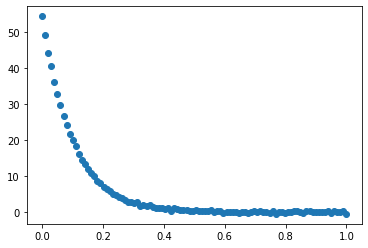

In [97]:
np.random.seed(2)
x = np.linspace(0,1,100)
xplot = np.linspace(0,1,100)
def f(x): return np.exp(-(x - 0.4)/ 0.1)
ytrue = f(x)
yplot = f(xplot)
y = ytrue + np.random.normal(scale=0.2, size=len(x))
plt.scatter(x,y)
BS = Bspline()

nr_splines = 100
l = 3
knot_type = "e"

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.98it/s]


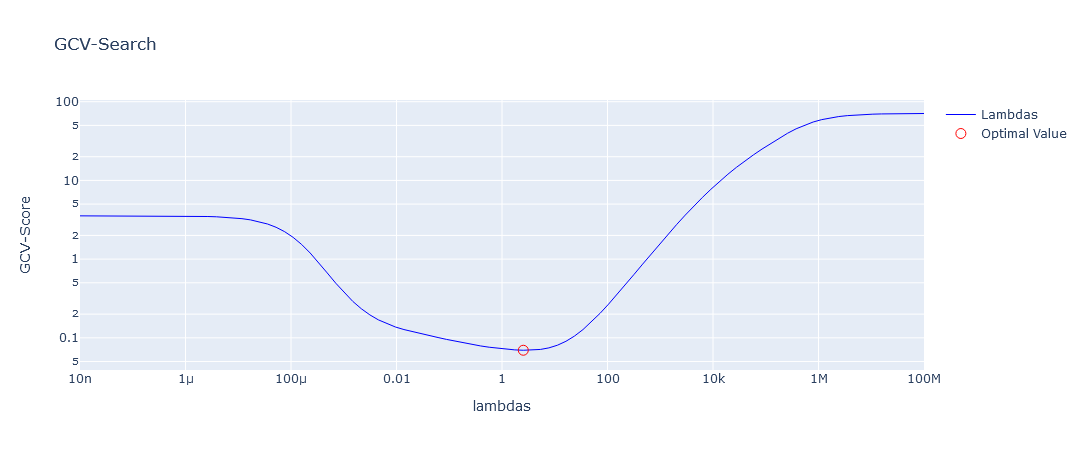

  9%|█████████████████▎                                                                                                                                                                               | 9/100 [00:00<00:01, 86.27it/s]

Best Lambda found =  2.5353644939701168


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.26it/s]


========Pre-Iteration=========
-------MSE = 0.0369057--------
======== Iteration 1 =========
-------MSE = 0.0384917--------
======== Iteration 2 =========
-------MSE = 0.0389159--------
======== Iteration 3 =========
-------MSE = 0.0390006--------
======== Iteration 4 =========
--------MSE = 0.039014--------


In [98]:
Bs = BS.fit(X=x, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type)
best_lam = BS.calc_GCV(X=x, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type, nr_lam=100)["best_lambda"]
print("Best Lambda found = ", best_lam)
Ps = BS.fit_Pspline(X=x, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type, lam=best_lam)
SCs = BS.fit_SC_Pspline(X=x, y=y, constraint="dec", nr_splines=nr_splines, l=l, knot_type=knot_type, lam_c=3000)

In [99]:
Bspred_plot = BS.predict(Xpred=xplot, coef=Bs["coef_"], knots=Bs["knots"], l=l)
Pspred_plot = BS.predict(Xpred=xplot, coef=Ps["coef_"], knots=Ps["knots"], l=l)
SCspred_plot = BS.predict(Xpred=xplot, coef=SCs["coef_"], knots=SCs["knots"], l=l)

---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


In [100]:
print("MSE on True and Fine Grid data".center(40,"="))
print("Tensor-product B-spline: ", mean_squared_error(Bspred_plot, yplot).round(6))
print("Tensor-product P-spline: ", mean_squared_error(Pspred_plot, yplot).round(6))
print("Tensor-product P-spline: ", mean_squared_error(SCspred_plot, yplot).round(6))

=====MSE on True and Fine Grid data=====
Tensor-product B-spline:  0.043448
Tensor-product P-spline:  0.008396
Tensor-product P-spline:  0.006688


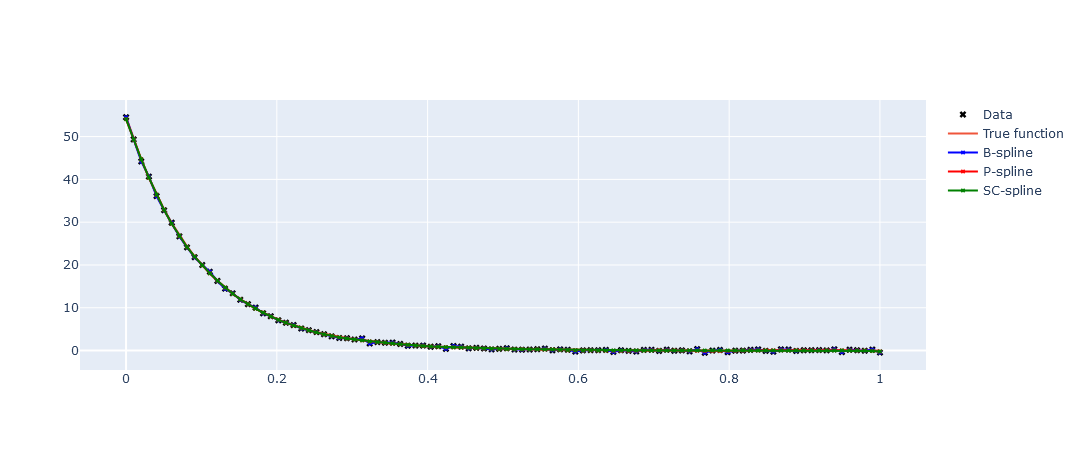

In [101]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", marker=dict(size=6, color="black", symbol="x"), name="Data"))
fig.add_trace(go.Scatter(x=xplot, y=yplot, name="True function"))
fig.add_trace(go.Scatter(x=xplot, y=Bspred_plot, mode="markers+lines", marker=dict(size=4, color="blue", symbol="x"), name="B-spline"))
fig.add_trace(go.Scatter(x=xplot, y=Pspred_plot, mode="markers+lines", marker=dict(size=4, color="red", symbol="x"), name="P-spline"))
fig.add_trace(go.Scatter(x=xplot, y=SCspred_plot, mode="markers+lines", marker=dict(size=4, color="green", symbol="x"), name="SC-spline"))

#fig = BS.plot_basis(knots=Ps["knots"], coef=Ps["coef_"], x=xplot, fig=fig, l=l)
fig.show()

### Test 2-D Fit using TP-spline, TP-P-spline and TP-SC-P-spline

In [4]:
np.random.seed(2)
#x1 = np.random.rand(1000)
#x2 = np.random.rand(1000)
x1 = np.linspace(0,1,5)
x1g, x2g = np.meshgrid(x1,x1)
data = np.vstack((x1g.ravel(),x2g.ravel())).T

def f(x1,x2): return np.exp(-(x2-0.5)**2) + x1**2

ztrue = f(data[:,0], data[:,1])
z = ztrue + np.random.normal(scale=0.02, size=len(ztrue))
df = pd.DataFrame(data=dict(x1=data[:,0], x2=data[:,1], z=z))
df_train, df_test = train_test_split(df)

In [5]:
xplot = np.linspace(0,1,25)
xplot1,xplot2 = np.meshgrid(xplot, xplot)
Xplot = np.vstack((xplot1.ravel(), xplot2.ravel())).T
zplot = f(xplot1.ravel(), xplot2.ravel())

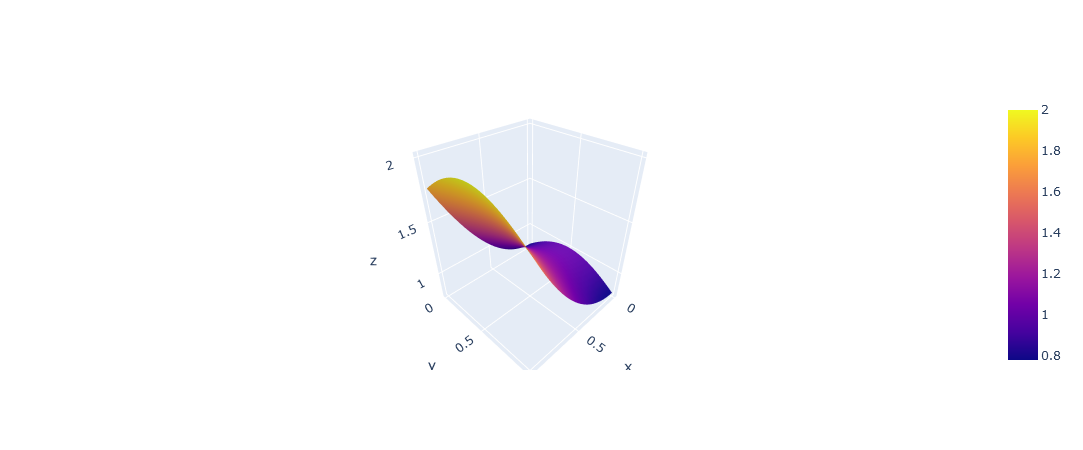

In [20]:
fig = go.Figure()
fig.add_trace(go.Surface(x=xplot1, y=xplot2, z=zplot.reshape(xplot1.shape)))

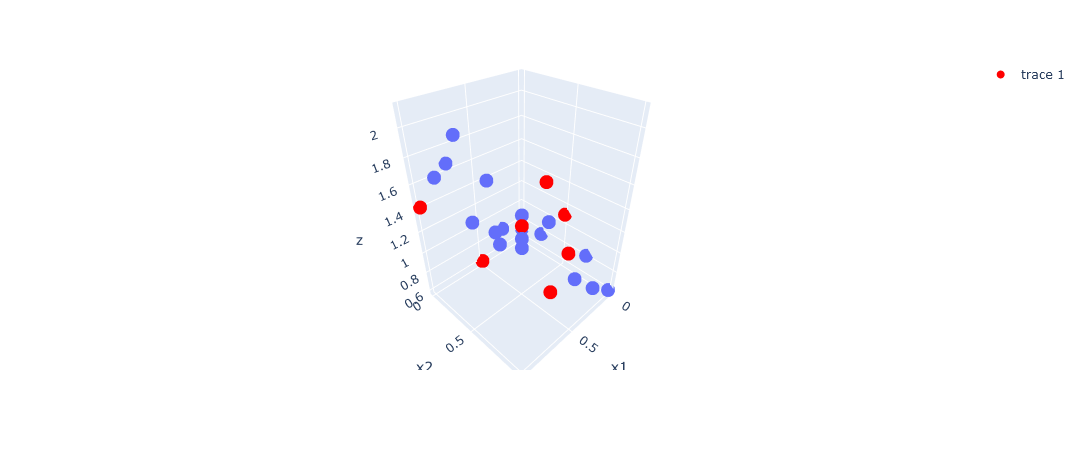

In [7]:
fig = px.scatter_3d(df_train, x="x1", y="x2", z="z")
fig.add_trace(go.Scatter3d(x=df_test["x1"], y=df_test["x2"], z=df_test["z"], mode="markers", marker=dict(color="red")))
fig.show()

In [6]:
nr_splines = (12,10)
l, knot_type = (3,3), ("e", "e")
BS = Bspline()
nr_lam = 10

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.91it/s]


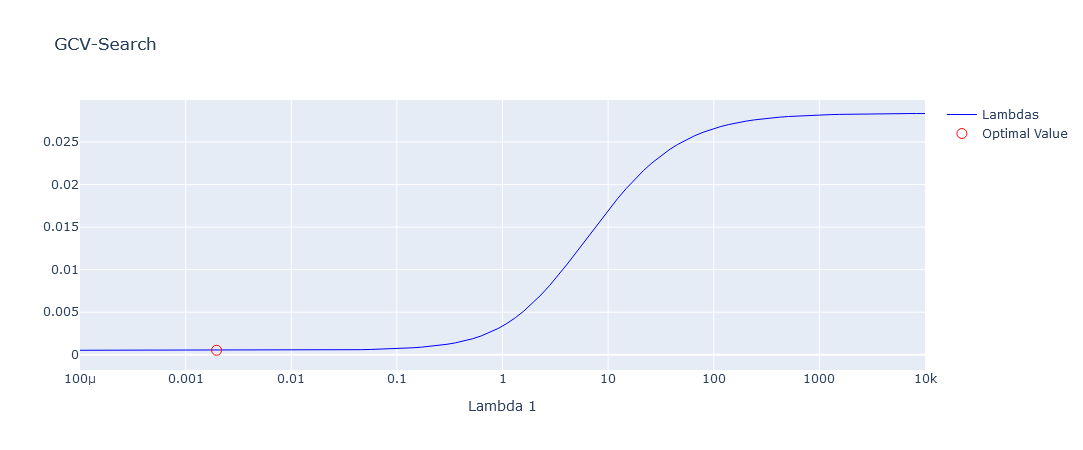

---unconstrained MSE = 0.0----
======== Iteration 1 =========
----------MSE = 0.0-----------


In [7]:
Bs = BS.fit(X=df_train[["x1", "x2"]].values, y=df_train["z"].values, 
            nr_splines=nr_splines, l=l, knot_type=knot_type)
best_lam=BS.calc_GCV_2d(df_train[["x1","x2"]].values, df_train["z"].values, nr_splines, nr_lam=20, plot_=0)
Ps = BS.fit_Pspline(X=df_train[["x1", "x2"]].values, y=df_train["z"].values, 
                    nr_splines=nr_splines, l=l, knot_type=knot_type, lam=best_lam["best_lambda"])
SCs = BS.fit_SC_TP_Pspline(X=df_train[["x1", "x2"]].values, y=df_train["z"].values,
                           constraints=("inc", "none"), nr_splines=nr_splines, l=l, knot_type=knot_type, lam_c=(6000,0))

In [8]:
Bspred = BS.predict(Xpred=df_test[["x1", "x2"]].values, coef=Bs["coef_"], knots=Bs["knots"], l=l)
Pspred = BS.predict(Xpred=df_test[["x1", "x2"]].values, coef=Ps["coef_"], knots=Ps["knots"], l=l)
SCspred = BS.predict(Xpred=df_test[["x1", "x2"]].values, coef=SCs["coef_"], knots=SCs["knots"], l=l)

Bspred_plot = BS.predict(Xpred=Xplot, coef=Bs["coef_"], knots=Bs["knots"], l=l)
Pspred_plot = BS.predict(Xpred=Xplot, coef=Ps["coef_"], knots=Ps["knots"], l=l)
SCspred_plot = BS.predict(Xpred=Xplot, coef=SCs["coef_"], knots=SCs["knots"], l=l)


---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----


In [9]:
print("MSE on Validation data".center(40,"="))
print("Tensor-product B-spline: ", mean_squared_error(Bspred, df_test["z"]).round(6))
print("Tensor-product P-spline: ", mean_squared_error(Pspred, df_test["z"]).round(6))
print("Tensor-product SC-P-spline: ", mean_squared_error(SCspred, df_test["z"]).round(6))
print("MSE on True and Fine Grid data".center(40,"="))
print("Tensor-product B-spline: ", mean_squared_error(Bspred_plot, zplot).round(6))
print("Tensor-product P-spline: ", mean_squared_error(Pspred_plot, zplot).round(6))
print("Tensor-product SC-P-spline: ", mean_squared_error(SCspred_plot, zplot).round(6))

=========MSE on Validation data=========
Tensor-product B-spline:  1.105943
Tensor-product P-spline:  0.001026
Tensor-product SC-P-spline:  0.001027
=====MSE on True and Fine Grid data=====
Tensor-product B-spline:  0.262947
Tensor-product P-spline:  0.000207
Tensor-product SC-P-spline:  0.000207


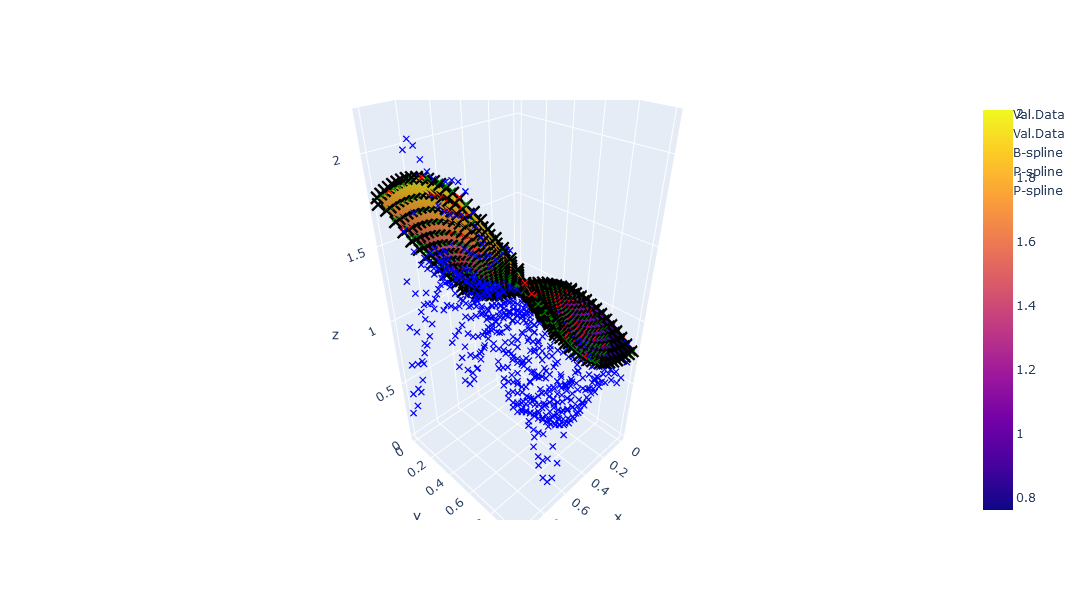

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=df_test["x1"], y=df_test["x2"], z=df_test["z"], 
    mode="markers", marker=dict(color="black", symbol="x", size=4), name="Val.Data"))
fig.add_trace(go.Scatter3d(
    x=Xplot[:,0], y=Xplot[:,1], z=zplot, 
    mode="markers", marker=dict(color="black", symbol="x", size=4), name="Val.Data"))
fig.add_trace(go.Scatter3d(
    x=Xplot[:,0], y=Xplot[:,1], z=Bspred_plot, 
    mode="markers", marker=dict(color="blue", symbol="x", size=2), name="B-spline"))
fig.add_trace(go.Scatter3d(
    x=Xplot[:,0], y=Xplot[:,1], z=Pspred_plot, 
    mode="markers", marker=dict(color="red", symbol="x", size=2), name="P-spline"))
fig.add_trace(go.Scatter3d(
    x=Xplot[:,0], y=Xplot[:,1], z=SCspred_plot, 
    mode="markers", marker=dict(color="green", symbol="x", size=2), name="P-spline"))

#fig.add_trace(go.Surface(x=xplot1, y=xplot2, z=Pspred_plot.reshape(xplot1.shape)))
fig.add_trace(go.Surface(x=xplot1, y=xplot2, z=SCspred_plot.reshape(xplot1.shape)))

fig.update_layout(height=600)

In [14]:
def check_constraint(coef, constraint="inc", y=None, B=None):
    """Check whether the coefficients in coef hold true to the constraint for
    the B-spline coefficients.

    Parameters:
    -----------
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    y  : array        - Output data.
    B  : matrix       - B-spline basis matrix.

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V.
    """

    threshold = 1e-4;
    if constraint not in ["inc", "dec", "conv","conc", "peak", "valley", "none"]:
        print(f"Constraint '{constraint}'' currently not available.")
        return

    if constraint == "inc":
        v = np.diff(coef) < threshold
    elif constraint == "dec":
        v = np.diff(coef) > -threshold
    elif constraint == "conv":
        v = np.diff(coef, 2) < threshold
    elif constraint == "conc":
        v = np.diff(coef, 2) > -threshold
    elif constraint == "peak":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y and B-spline basis matrix B."
        peakidx = np.argmax(y)
        peak_spline_idx = np.argmax(B[peakidx,:])
        v = list(np.diff(coef[:peak_spline_idx]) < threshold) + [0] + list(np.diff(coef[peak_spline_idx:]) > -threshold)
        v = np.array(v)
    elif constraint == "valley":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y and B-spline basis matrix B."
        valleyidx = np.argmin(y)
        valley_spline_idx = np.argmin(B[peakidx,:])
        v = list(np.diff(coef[:peak_spline_idx]) > -threshold) + [False] + list(np.diff(coef[peak_spline_idx:]) < threshold)
        v = np.array(v)
    else:
        v = np.zeros(len(coef)-2)
    return list(v.astype(int))

def check_constraint_tp(coef, nr_param=(10,10), constraint="inc", direction=1):
    """Check whether the coefficients in coef hold true to the constraint for 
    the tensor-product B-spline coefficients.

    Parameters:
    -----------
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    direction : int   - Either 0 or 1 indication the direction of the constraint. 
                        2 is row-wise (2nd dimension) and 1 is column-wise (1st dimension

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V.
    """

    threshold = 1e-12 #1e-4;
    if constraint not in ["inc", "dec", "conv","conc", "none"]:
        print(f"The constraint '{constraint}' is not available.")
        return
    if direction == 1:
        dim = 1
    elif direction == 1:
        dim = 0
    
    if constraint == "inc":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), axis=dim) < threshold
    elif constraint == "dec":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), axis=dim) > -threshold
    elif constraint == "conv":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), 2,  axis=dim) < threshold
    elif constraint == "conc":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), 2,  axis=dim) > -threshold
    else:
        v = np.zeros(nr_param[0]*nr_param[1])
    return list(v.ravel().astype(int))

def check_constraint_full(coef_, descr, basis=0, y=0):
    """Checks the respective parts of the coef vector against 
    the respective constraint constraints. 
    
    Paramters:
    ----------
    coef_ : array    - Vector of coefficients.
    descr : tuple    - Model description.
    
    Returns:
    --------
    v : list    - Diagonal elements of the weighting matrix V.
    
    """
    i, v = 0, []
    for e in descr:
        if e[0].startswith("s"):
            c = coef_[i:e[1]+i]
            v.append(check_constraint(c, e[2], y=y, B=basis[:, i:e[1]+i]))
        elif e[0].startswith("t"):
            c = coef_[i:np.prod(e[1])+i]
            v1 = check_constraint_tp(c, e[1], constraint=e[2][0], direction=0)
            v2 = check_constraint_tp(c, e[1], constraint=e[2][1], direction=0)
            v.append((v1,v2))
        else:
            print("Only B-splines (s) and tensor-product B-splines (t) are supported!")
            return
        i += np.prod(e[1])
    return v

## Peak Example for Chapter 4

In [57]:
savePath = os.path.join(os.path.dirname("."), '../../Thesis/tex/graphics/data/cha4/peak_example/')
print("Generate linspace some data")
np.random.seed(2)
n_data = 200
#x = np.random.random(n_data)*10
x = np.linspace(0.1,0.8,n_data)
ytrue = 2*np.exp(-(x-0.35)**2/0.01)
noise = np.random.normal(loc=0, scale=0.1, size=x.shape)
y = ytrue + noise

# train-test split
print("Perform train-test split")
df = pd.DataFrame(data=dict(x=x, y=y, ytrue=ytrue))
df_train, df_test = train_test_split(df)


Generate linspace some data
Perform train-test split


In [58]:
print("Fit the different spline types")
nr_splines, knot_type, spline_order, lam_c = 35, "e", 3, 6000
B = Bspline()
sol = B.fit(df_train["x"].values, df_train["y"].values, nr_splines=nr_splines)
opt_lam = B.calc_GCV(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines, nr_lam=100, plot_=0)["best_lambda"]
print("Optimal lambda = ",opt_lam)
sol_p = B.fit_Pspline(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines,lam=opt_lam)
sol_c = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=lam_c)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 716.42it/s]

Fit the different spline types
Optimal lambda =  3.6783797718286344



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 768.89it/s]

========Pre-Iteration=========
-------MSE = 0.0110801--------
======== Iteration 1 =========
-------MSE = 0.0111388--------
======== Iteration 2 =========
-------MSE = 0.0111386--------


In [59]:
print("Show the mean squared errors")
Bspline_pred = B.predict(df_test["x"].values, sol["coef_"], sol["knots"])
Pspline_pred = B.predict(df_test["x"].values, sol_p["coef_"], sol_p["knots"])
SCPspline_pred = B.predict(df_test["x"].values, sol_c["coef_"], sol_c["knots"])

print("".center(50,"="))
print("".center(50,"="))
print("MSEs compared to True Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(6))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(6))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, SCPspline_pred).round(6))
print("".center(50,"="))
print("Train Set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(6))
print("MSE-Train P-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(6))
print("MSE-Train SC-P-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(6))
print("".center(50,"="))
print("MSEs compared to Noisy Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Bspline_pred).round(6))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Pspline_pred).round(6))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, SCPspline_pred).round(6))
print("".center(50,"="))
print("Train set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(6))
print("MSE-Train P-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(6))
print("MSE-Train SC-P-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(6))
print("".center(50,"="))

Show the mean squared errors
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
MSEs compared to True Function
        Validation Set        
MSE-Val B-spline =        0.005977
MSE-Val P-spline =        0.001541
MSE-Val SC-P-spline =     0.001498
          Train Set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.002697
---Prediction for 1-D Data----
MSE-Train P-spline =      0.001227
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.001168
MSEs compared to Noisy Function
        Validation Set        
MSE-Val B-spline =        0.018768
MSE-Val P-spline =        0.012168
MSE-Val SC-P-spline =     0.012137
          Train set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.009351
---Prediction for 1-D Data----
MSE-Train P-spline =      0.01108
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.011139


In [11]:
# add the predictions to the dataset and save it
xplot = np.linspace(0.1,0.8,200)
Bspline_plot = B.predict(xplot, sol["coef_"], sol["knots"])
Pspline_plot = B.predict(xplot, sol_p["coef_"], sol_p["knots"])
SCPspline_plot = B.predict(xplot, sol_c["coef_"], sol_c["knots"])

---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


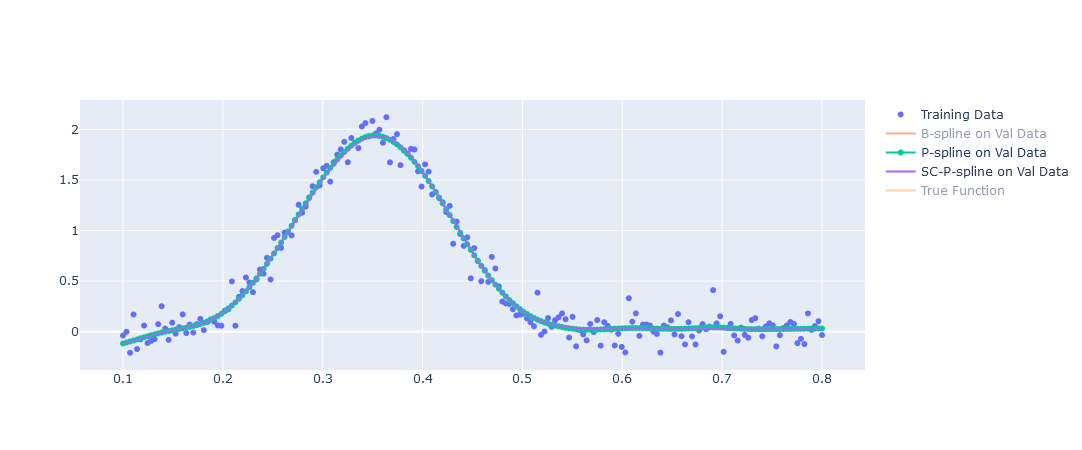

In [12]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="Training Data"))
fig.add_trace(go.Scatter(x=xplot, y=Bspline_plot, mode="lines", name="B-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=Pspline_plot, mode="lines+markers", name="P-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot, mode="lines", name="SC-P-spline on Val Data"))
fig.add_trace(go.Scatter(x=x, y=ytrue, mode="lines", name="True Function"))

In [11]:
df_mse = pd.DataFrame(columns=["Model", "MSEVal", "MSEValTrueFunction"])
df_mse["Model"] = ["B-spline", "P-spline", "SCP-spline"]
df_mse["MSEValTrueFunction"] = [
    mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(6),
    mean_squared_error(df_test["ytrue"].values, SCPspline_pred).round(6)]
df_mse["MSEVal"] = [
    mean_squared_error(df_test["y"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["y"].values, Pspline_pred).round(6),
    mean_squared_error(df_test["y"].values, SCPspline_pred).round(6)
]

df_info = pd.DataFrame(columns=["Info", "Value"])
df_info["Info"] = ["Nr_splines", "Knot_type", "Spline_Order", "Opt_Lambda", "Lambda_c"]
df_info["Value"] = [nr_splines, knot_type, spline_order, opt_lam, lam_c]

df_plot = pd.DataFrame(data=dict(xplot=xplot, yplot=y, ytrue=ytrue,
                                Bspline_fit=Bspline_plot,
                                Pspline_fit=Pspline_plot,
                                SCP_spline_fit=SCPspline_plot))
#df_info.to_csv(savePath+"info.txt", sep=" ", index=False)
#df_mse.to_csv(savePath+"mse.csv", sep=",", index=False)
#df_plot.to_csv(savePath+"data.txt", sep=" ", index=0)

## Peak example for different $\lambda_c$ for Chapter 4

Generate some data for the experiment: Different Lambdas


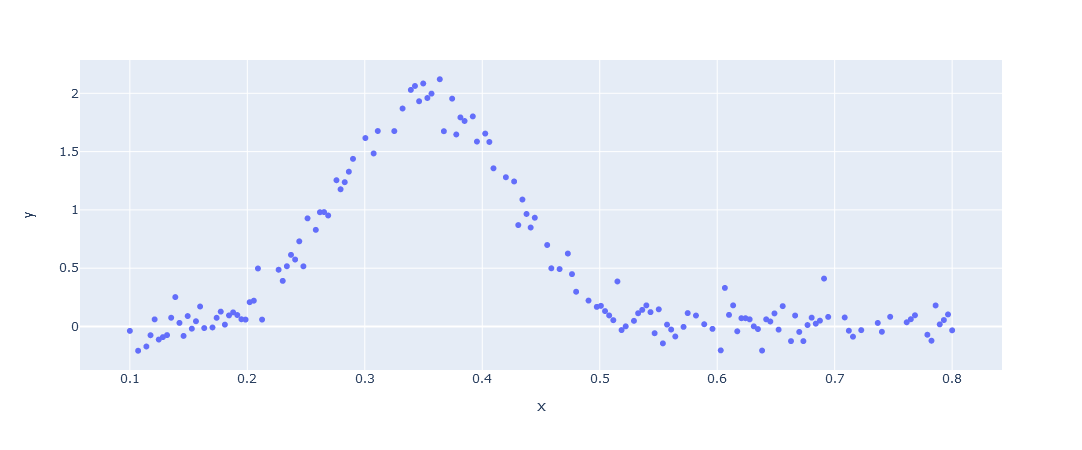

In [60]:
savePath = os.path.join(os.path.dirname("."), '../../Thesis/tex/graphics/data/cha4/lambdas/')
print("Generate some data for the experiment: Different Lambdas")
np.random.seed(2)
n_data = 200
#x = np.random.random(n_data)*10
x = np.linspace(0.1,0.8,n_data)
ytrue = 2*np.exp(-(x-0.35)**2/0.01)
noise = np.random.normal(loc=0, scale=0.1, size=x.shape)
y = ytrue + noise

# train-test split
df = pd.DataFrame(data=dict(x=x, y=y, ytrue=ytrue))
df_train, df_test = train_test_split(df)

px.scatter(df_train, x="x", y="y")

In [61]:
print("Fit the different spline types")
nr_splines, knot_type, spline_order, lam_c = 45, "e", 3, 6000
B = Bspline()
# Calculate B-spline fit
sol = B.fit(df_train["x"].values, df_train["y"].values, nr_splines=nr_splines, knot_type=knot_type)
# Perform generalized cross-validation
opt_lam = B.calc_GCV(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines, knot_type=knot_type, nr_lam=100, plot_=0)["best_lambda"]
print("Optimal lambda = ",opt_lam)
# Calculate optimal P-spline fit
sol_p = B.fit_Pspline(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines,lam=opt_lam, knot_type=knot_type)
# Calculate the SC-P-spline fits
sol_c = {}
for c in [0,1,10,100,1000,10000]:
    sol_c["sol_c"+str(c)] = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=c, knot_type=knot_type)

 22%|██████████████████████████████████████████                                                                                                                                                     | 22/100 [00:00<00:00, 217.27it/s]

Fit the different spline types


 26%|█████████████████████████████████████████████████▋                                                                                                                                             | 26/100 [00:00<00:00, 247.69it/s]

Optimal lambda =  7.742636826811277


 23%|███████████████████████████████████████████▉                                                                                                                                                   | 23/100 [00:00<00:00, 219.47it/s]

========Pre-Iteration=========
-------MSE = 0.0110116--------
======== Iteration 1 =========
-------MSE = 0.0110116--------


 20%|██████████████████████████████████████▏                                                                                                                                                        | 20/100 [00:00<00:00, 194.95it/s]

========Pre-Iteration=========
-------MSE = 0.0110116--------
======== Iteration 1 =========
-------MSE = 0.0110141--------


 24%|█████████████████████████████████████████████▊                                                                                                                                                 | 24/100 [00:00<00:00, 218.07it/s]

========Pre-Iteration=========
-------MSE = 0.0110116--------
======== Iteration 1 =========
-------MSE = 0.0110301--------


 21%|████████████████████████████████████████                                                                                                                                                       | 21/100 [00:00<00:00, 190.88it/s]

========Pre-Iteration=========
-------MSE = 0.0110116--------
======== Iteration 1 =========
-------MSE = 0.0110643--------
======== Iteration 2 =========
-------MSE = 0.0110646--------


 25%|███████████████████████████████████████████████▊                                                                                                                                               | 25/100 [00:00<00:00, 249.70it/s]

========Pre-Iteration=========
-------MSE = 0.0110116--------
======== Iteration 1 =========
-------MSE = 0.0110768--------
======== Iteration 2 =========
-------MSE = 0.0110792--------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 214.99it/s]


========Pre-Iteration=========
-------MSE = 0.0110116--------
======== Iteration 1 =========
-------MSE = 0.0110785--------
======== Iteration 2 =========
-------MSE = 0.0110812--------


In [62]:
print("Calculate predicted values for validation data.")
Bspline_pred = B.predict(df_test["x"].values, sol["coef_"], sol["knots"])
Pspline_pred = B.predict(df_test["x"].values, sol_p["coef_"], sol_p["knots"])
SCPspline_pred_c = dict()
for k,v in sol_c.items():
    SCPspline_pred_c[k.split("_")[-1]] = B.predict(df_test["x"].values, v["coef_"], v["knots"])

Calculate predicted values for validation data.
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


In [63]:
r, lj = 8, 30
print("".center(50,"="))
print("MSEs compared to True Function")
print("Validation Set".center(lj, " "))
print("".center(50,"="))
print("MSE-Val B-spline = ".ljust(lj), mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(r))
print("MSE-Val P-spline = ".ljust(lj), mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(r))
for k,v in SCPspline_pred_c.items():
    print(f"MSE-Val SC-P-spline {k} = ".ljust(lj), mean_squared_error(df_test["ytrue"].values, v).round(r))
print("".center(50,"="))

MSEs compared to True Function
        Validation Set        
MSE-Val B-spline =             0.00703914
MSE-Val P-spline =             0.00152137
MSE-Val SC-P-spline c0 =       0.00152137
MSE-Val SC-P-spline c1 =       0.00152153
MSE-Val SC-P-spline c10 =      0.0015135
MSE-Val SC-P-spline c100 =     0.00149088
MSE-Val SC-P-spline c1000 =    0.0014819
MSE-Val SC-P-spline c10000 =   0.00148074


In [64]:
print("".center(50,"="))
print("MSEs compared to Noisy Function")
print("Validation Set".center(30, " "))
print("".center(50,"="))
print("MSE-Val B-spline = ".ljust(lj), mean_squared_error(df_test["y"].values, Bspline_pred).round(r))
print("MSE-Val P-spline = ".ljust(lj), mean_squared_error(df_test["y"].values, Pspline_pred).round(r))
for k,v in SCPspline_pred_c.items():
    print(f"MSE-Val SC-P-spline {k} = ".ljust(lj), mean_squared_error(df_test["y"].values, v).round(r))
print("".center(50,"="))

MSEs compared to Noisy Function
        Validation Set        
MSE-Val B-spline =             0.01903915
MSE-Val P-spline =             0.01222459
MSE-Val SC-P-spline c0 =       0.01222459
MSE-Val SC-P-spline c1 =       0.01222266
MSE-Val SC-P-spline c10 =      0.0122063
MSE-Val SC-P-spline c100 =     0.01218939
MSE-Val SC-P-spline c1000 =    0.01219054
MSE-Val SC-P-spline c10000 =   0.01219098


In [65]:
print("".center(50,"="))
print("MSEs compared to Noisy Function")
print("Train Set".center(lj, " "))
print("".center(50,"="))
print("MSE-Train B-spline = ".ljust(lj), 
      mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(r))
print("MSE-Train P-spline = ".ljust(lj), 
      mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(r))
for k,v in sol_c.items():
    print(f"MSE-Val SC-P-spline {k.split('_')[-1]} = ".ljust(lj), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, v["coef_"], v["knots"])).round(r))
print("".center(50,"="))

MSEs compared to Noisy Function
          Train Set           
---Prediction for 1-D Data----
MSE-Train B-spline =           0.00338152
---Prediction for 1-D Data----
MSE-Train P-spline =           0.00119977
---Prediction for 1-D Data----
MSE-Val SC-P-spline c0 =       0.00119977
---Prediction for 1-D Data----
MSE-Val SC-P-spline c1 =       0.001197
---Prediction for 1-D Data----
MSE-Val SC-P-spline c10 =      0.00118163
---Prediction for 1-D Data----
MSE-Val SC-P-spline c100 =     0.00115461
---Prediction for 1-D Data----
MSE-Val SC-P-spline c1000 =    0.00114585
---Prediction for 1-D Data----
MSE-Val SC-P-spline c10000 =   0.00114478


---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


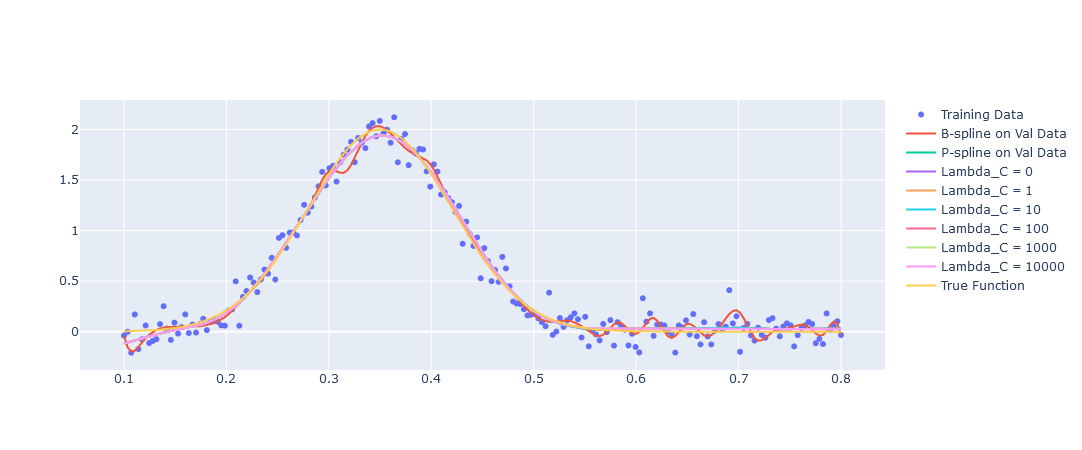

In [66]:
# calculate predictions on finer grid and plot it
xplot = np.linspace(df_train["x"].min(),df_train["x"].max(),200)
Bspline_plot = B.predict(xplot, sol["coef_"], sol["knots"])
Pspline_plot = B.predict(xplot, sol_p["coef_"], sol_p["knots"])
SCPspline_plot0 = B.predict(xplot, sol_c["sol_c0"]["coef_"], sol_c["sol_c0"]["knots"])
SCPspline_plot1 = B.predict(xplot, sol_c["sol_c1"]["coef_"], sol_c["sol_c1"]["knots"])
SCPspline_plot10 = B.predict(xplot, sol_c["sol_c10"]["coef_"], sol_c["sol_c10"]["knots"])
SCPspline_plot100 = B.predict(xplot, sol_c["sol_c100"]["coef_"], sol_c["sol_c100"]["knots"])
SCPspline_plot1000 = B.predict(xplot, sol_c["sol_c1000"]["coef_"], sol_c["sol_c1000"]["knots"])
SCPspline_plot10000 = B.predict(xplot, sol_c["sol_c10000"]["coef_"], sol_c["sol_c10000"]["knots"])

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="Training Data"))
fig.add_trace(go.Scatter(x=xplot, y=Bspline_plot, mode="lines", name="B-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=Pspline_plot, mode="lines+markers", marker=dict(size=1), name="P-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot0, mode="lines", name="Lambda_C = 0"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot1, mode="lines", name="Lambda_C = 1"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot10, mode="lines", name="Lambda_C = 10"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot100, mode="lines", name="Lambda_C = 100"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot1000, mode="lines", name="Lambda_C = 1000"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot10000, mode="lines", name="Lambda_C = 10000"))

fig.add_trace(go.Scatter(x=x, y=ytrue, mode="lines", name="True Function"))

In [102]:
df_mse = pd.DataFrame(columns=["Model", "MSEVal", "MSEValTrueFunction"])
df_mse["Model"] = ["B-spline", "P-spline"] + [s.split("_")[-1] for s in list(sol_c.keys())]
df_mse["MSEValTrueFunction"] = [
    mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(6)] + [mean_squared_error(df_test["ytrue"].values, v).round(6) for k,v in SCPspline_pred_c.items()]

df_mse["MSEVal"] = [
    mean_squared_error(df_test["y"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["y"].values, Pspline_pred).round(6)] + [mean_squared_error(df_test["y"].values, B.predict(df_test["x"], v["coef_"], v["knots"])).round(6) for k,v in sol_c.items()]

---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


In [103]:
df_info = pd.DataFrame(columns=["Info", "Value"])
df_info["Info"] = ["Nr_splines", "Knot_type", "Spline_Order", "Opt_Lambda", "Lambda_c"]
lams = [v["lambdas"][1] for k,v in sol_c.items()]
df_info["Value"] = [nr_splines, knot_type, spline_order, opt_lam, lams]

In [141]:
df_plot = pd.DataFrame(data=dict(xplot=xplot, yplot=y, 
                                Bspline_fit=Bspline_plot,
                                Pspline_fit=Pspline_plot,
                                c0=SCPspline_plot0, c1=SCPspline_plot1, 
                                c10=SCPspline_plot10, c100=SCPspline_plot100, 
                                c1000=SCPspline_plot1000, c10000=SCPspline_plot10000))

In [142]:
df_info.to_csv(savePath+"info.txt", sep=" ", index=False)
df_mse.to_csv(savePath+"mse.csv", sep=",", index=False)
df_plot.to_csv(savePath+"data.txt", sep=" ", index=0)

<AxesSubplot:>

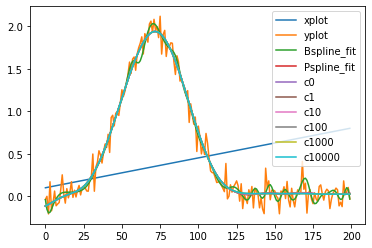

## Peak Example for Sparse Data in Chapter 4

Generate sparse data


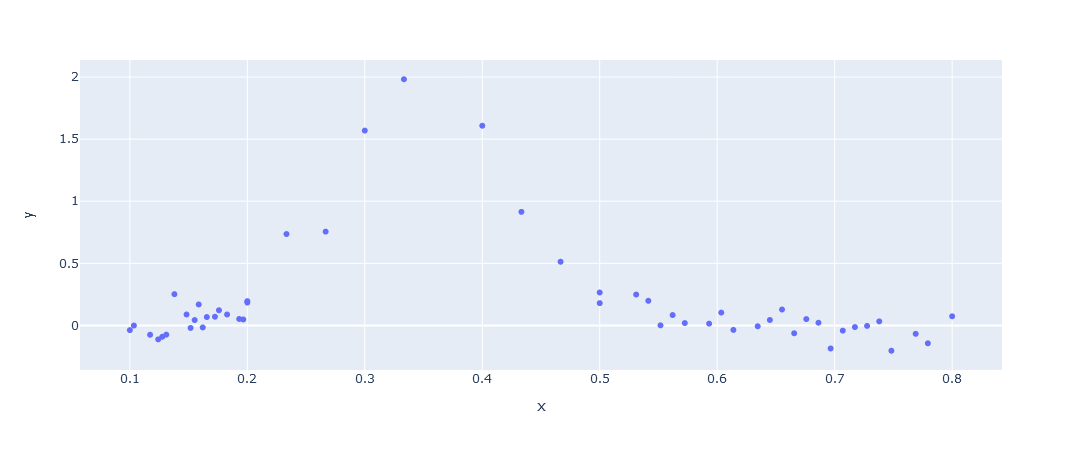

In [25]:
savePath = os.path.join(os.path.dirname("."), '../../Thesis/tex/graphics/data/cha4/sparse_example/')
print("Generate sparse data")
np.random.seed(2)
n_data = 200
x1 = np.linspace(0.1,0.2, 30)
x2 = np.linspace(0.2,0.5, 10)
x3 = np.linspace(0.5,0.8, 30)
x = np.hstack((x1,x2,x3))

ytrue = 2*np.exp(-(x-0.35)**2/0.01) 
noise = np.random.normal(loc=0, scale=0.1, size=x.shape)
y = ytrue + noise

# train-test split
df = pd.DataFrame(data=dict(x=x, y=y, ytrue=ytrue))
df_train, df_test = train_test_split(df)

px.scatter(df_train, x="x", y="y")

In [32]:
print("Fit the different spline types")
nr_splines, knot_type, spline_order, lam_c = 30, "q", 3, 1000
B = Bspline()
sol = B.fit(df_train["x"].values, df_train["y"].values, nr_splines=nr_splines, knot_type=knot_type)
opt_lam = B.calc_GCV(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines, nr_lam=100, plot_=0, knot_type=knot_type)["best_lambda"]
print("Optimal lambda = ",opt_lam)
sol_p = B.fit_Pspline(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines,lam=opt_lam, knot_type=knot_type)
sol_c = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=lam_c, knot_type=knot_type)

Fit the different spline types
Optimal lambda =  0.006579332246575682
========Pre-Iteration=========
-------MSE = 0.0046824--------
======== Iteration 1 =========
-------MSE = 0.0066226--------
======== Iteration 2 =========
--------MSE = 0.007056--------
======== Iteration 3 =========
-------MSE = 0.0070819--------


In [33]:
print("Show the mean squared errors")
Bspline_pred = B.predict(df_test["x"].values, sol["coef_"], sol["knots"])
Pspline_pred = B.predict(df_test["x"].values, sol_p["coef_"], sol_p["knots"])
SCPspline_pred = B.predict(df_test["x"].values, sol_c["coef_"], sol_c["knots"])

Show the mean squared errors
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


In [34]:
print("".center(50,"="))
print("".center(50,"="))
print("MSEs compared to True Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(6))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(6))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, SCPspline_pred).round(6))
print("".center(50,"="))
print("Train Set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(6))
print("MSE-Train P-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(6))
print("MSE-Train SC-P-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(6))
print("".center(50,"="))
print("MSEs compared to Noisy Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Bspline_pred).round(6))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Pspline_pred).round(6))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, SCPspline_pred).round(6))
print("".center(50,"="))
print("Train set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(6))
print("MSE-Train P-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(6))
print("MSE-Train SC-P-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(6))
print("".center(50,"="))

MSEs compared to True Function
        Validation Set        
MSE-Val B-spline =        0.009236
MSE-Val P-spline =        0.00645
MSE-Val SC-P-spline =     0.00356
          Train Set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.005914
---Prediction for 1-D Data----
MSE-Train P-spline =      0.004081
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.002065
MSEs compared to Noisy Function
        Validation Set        
MSE-Val B-spline =        0.025241
MSE-Val P-spline =        0.020679
MSE-Val SC-P-spline =     0.015905
          Train set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.003826
---Prediction for 1-D Data----
MSE-Train P-spline =      0.004682
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.007082


In [35]:
# add the predictions to the dataset and save it
xplot = np.linspace(0.1,0.8,1000)
yplot = 2*np.exp(-(xplot-0.35)**2/0.01) 
Bspline_plot = B.predict(xplot, sol["coef_"], sol["knots"])
Pspline_plot = B.predict(xplot, sol_p["coef_"], sol_p["knots"])
SCPspline_plot = B.predict(xplot, sol_c["coef_"], sol_c["knots"])

---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


Knot type:  q


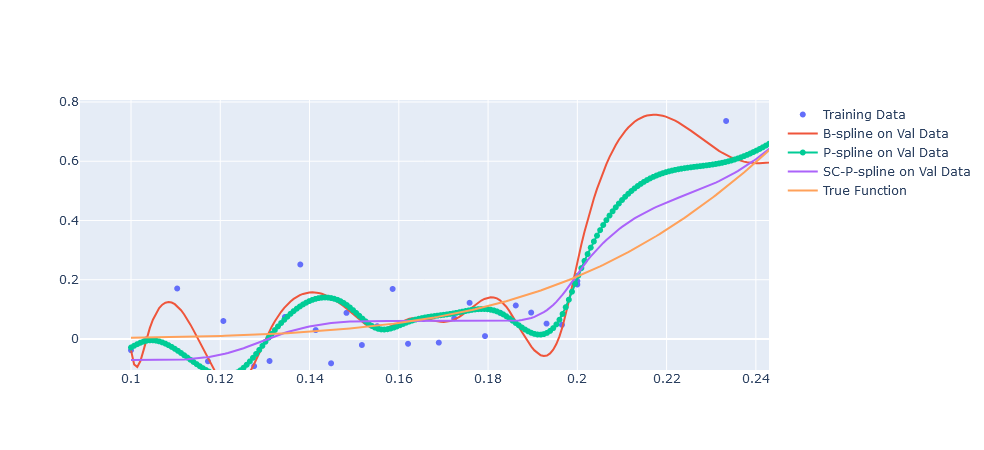

In [36]:
fig = go.Figure()
print("Knot type: ", knot_type)
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="Training Data"))
fig.add_trace(go.Scatter(x=xplot, y=Bspline_plot, mode="lines", name="B-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=Pspline_plot, mode="lines+markers", name="P-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot, mode="lines", name="SC-P-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=yplot, mode="lines", name="True Function"))
fig.update_yaxes(range=[-2, 4])

In [17]:
df_mse = pd.DataFrame(columns=["Model", "MSEVal", "MSEValTrueFunction"])
df_mse["Model"] = ["B-spline", "P-spline", "SCP-spline"]
df_mse["MSEValTrueFunction"] = [
    mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(6),
    mean_squared_error(df_test["ytrue"].values, SCPspline_pred).round(6)]
df_mse["MSEVal"] = [
    mean_squared_error(df_test["y"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["y"].values, Pspline_pred).round(6),
    mean_squared_error(df_test["y"].values, SCPspline_pred).round(6)
]

df_info = pd.DataFrame(columns=["Info", "Value"])
df_info["Info"] = ["Nr_splines", "Knot_type", "Spline_Order", "Opt_Lambda", "Lambda_c"]
df_info["Value"] = [nr_splines, knot_type, spline_order, opt_lam, lam_c]
df_plot_fit = pd.DataFrame(data=dict(xplot=xplot, yplot=yplot,
                                     Bspline_fit=Bspline_plot,
                                     Pspline_fit=Pspline_plot,
                                     SCP_spline_fit=SCPspline_plot))
df_plot_data = pd.DataFrame(data=dict(x=x, y=y))

In [18]:
df_mse.to_csv(savePath+f"mse-{knot_type}.csv", sep=",", index=False)
df_info.to_csv(savePath+f"info-{knot_type}.txt", sep=" ", index=False)
df_plot_data.to_csv(savePath+f"data-{knot_type}.txt", sep=" ", index=False)
df_plot_fit.to_csv(savePath+f"fit-{knot_type}.txt", sep=" ", index=False)

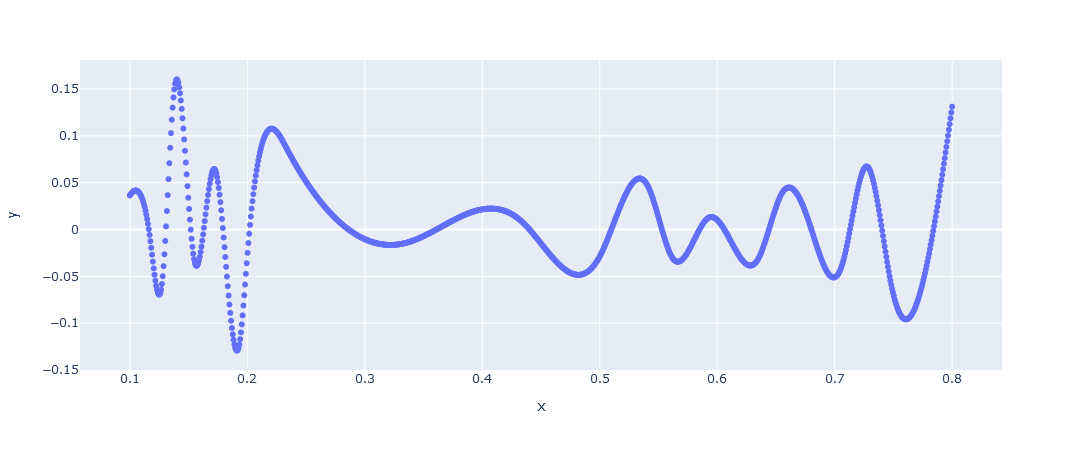

In [11]:
px.scatter(x=xplot, y=Pspline_plot- SCPspline_plot)

In [13]:
def star_model(descr, X, y):
        
    BS, TS = Bspline(), Bspline()
    basis, smoothness = [], []
    constraints, optimal_lambdas = [], []
    weights, coef_ = [], []
    S, K = [], []

    for e in descr:
        if e[0].startswith("s"):
            B = BS.basismatrix(X=X[:,int(e[0][2])-1], nr_splines=e[1], l=3, knot_type=e[-1])["basis"]
            D = mapping_matrix(n_param=e[1], constraint="smooth")
            C = mapping_matrix(n_param=e[1], constraint=e[2])
            lam = BS.calc_GCV(X=X[:,int(e[0][2])-1], y=y, nr_splines=e[1], l=3, knot_type=e[-1], nr_lam=50, plot_=0)["best_lambda"]
            coef_pls = BS.fit_Pspline(X=X[:,int(e[0][2])-1], y=y, nr_splines=e[1], l=3, knot_type=e[-1], lam=lam)["coef_"]
            weights.append(check_constraint(coef=coef_pls, constraint=e[2], y=y, B=B))
        elif e[0].startswith("t"):
            B = TS.tensorproduct_basismatrix(X=X[:,[int(e[0][2])-1, int(e[0][4])-1]], nr_splines=e[1], l=(3,3), knot_type=e[-1])["basis"]
            D = mapping_matrix_tp(n_param=e[1], constraints=("smooth", "smooth"))
            C = mapping_matrix_tp(n_param=e[1], constraints=e[2])
            lam = TS.calc_GCV(X=X[:,[int(e[0][2])-1, int(e[0][4])-1]], y=y, nr_splines=e[1], l=(3,3), knot_type=e[-1], nr_lam=50, plot_=0)["best_lambda"]
            coef_pls = TS.fit_Pspline(X=X[:,[int(e[0][2])-1, int(e[0][4])-1]], y=y, nr_splines=e[1], l=(3,3), knot_type=e[-1], lam=(lam, lam))["coef_"]
            weights1 = check_constraint_tp(coef_pls, nr_param=e[1], constraint=e[2][0], direction=1)
            weights2 = check_constraint_tp(coef_pls, nr_param=e[1], constraint=e[2][1], direction=0)
            weights.append((weights1,weights2))
        else:
            print("Only B-splines (s) and tensor-product B-splines (t) are supported!")
            return
        basis.append(B)
        smoothness.append(D)
        constraints.append(C)
        optimal_lambdas.append(lam)
        coef_.append(coef_pls)
        
    # create combined basis matrix
    B = np.concatenate(basis, axis=1)
    # create combined smoothness matrix
    for i, s in enumerate(smoothness):
        if len(s) == 2:
            S.append(optimal_lambdas[i]*(s[0].T @ s[0]) + optimal_lambdas[i]*(s[1].T@s[1]))
        else:
            S.append(optimal_lambdas[i]* (s.T@s))
    S = block_diag(*S)
    # create combined constraint matrix
    for i, c in enumerate(constraints):
        if len(c) == 2:
            K.append(6000*(c[0].T @ np.diag(weights[i][0]) @ c[0]) + 6000*(c[1].T @np.diag(weights[i][1]) @ c[1]))
        else:
            K.append(6000* (c.T@ np.diag(weights[i])@c))
    K = block_diag(*K)
    
    weights_old = [0]*len(weights)
    iterIdx = 1
    BtB = B.T @ B
    Bty = B.T @ y
    
    # Iterate till no change in weights
    while not (weights == weights_old):
        weights_old = weights
        coef_ = np.linalg.pinv(BtB + S + K) @ (Bty)
        weights = check_constraint_full(coef_=coef_, descr=m, basis=B, y=y)

        print(f" Iteration {iterIdx} ".center(50, "="))
        print(f"MSE = {mean_squared_error(y, B@coef_).round(7)}".center(50, "-"))
        
        K = []
        print("Calculate new constraint matrix K".center(50,"-"))
        for i, c in enumerate(constraints):
            if len(c) == 2:
                K.append(descr[i][3]*(c[0].T @ np.diag(weights[i][0]) @ c[0]) + descr[i][3]*(c[1].T @np.diag(weights[i][1]) @ c[1]))
            else:
                K.append(descr[i][3]*(c.T@ np.diag(weights[i])@c))
        K = block_diag(*K)

        if iterIdx > 200:
            print("breaking")
            break

        iterIdx += 1
        
        
    return dict(basis=B, smoothness=S, constraint=K, opt_lambdas=optimal_lambdas, coef_=coef_, weights=weights)


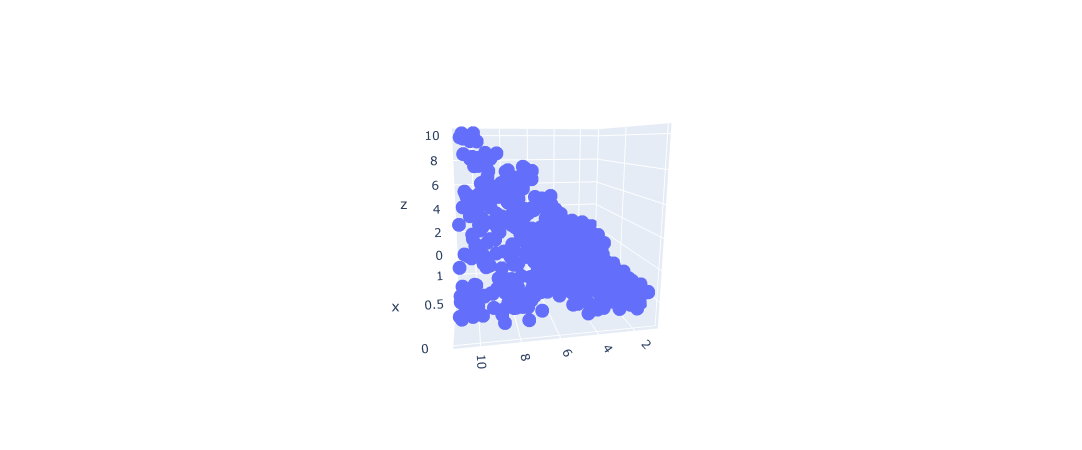

In [43]:
px.scatter_3d(x=XX[:,0],y=XX[:,1], z=y)

In [35]:
m = ( ("t(1,2)", (5,5), ("none", "none"), 6000, ("e", "q")), 
      ("s(1)", 100, "peak", 6000, "e"), 
      ("s(2)", 100, "inc", 6000, "q"), 
 )
XX = np.array([np.random.uniform(0,1,500), np.random.uniform(1,11, 500)]).T
#XX = np.array([np.linspace(0,1,25), np.linspace(1,11,25)]).T

y = XX[:,0]**2 * XX[:,1] + np.exp(-(XX[:,1] - 6)**2) + np.random.normal(size=XX[:,0].shape)*0.5

In [36]:
sol = star_model(m, XX, y)

================== Iteration 1 ===================
-----------------MSE = 0.2514827------------------
--------Calculate new constraint matrix K---------
================== Iteration 2 ===================
-----------------MSE = 0.2501727------------------
--------Calculate new constraint matrix K---------
================== Iteration 3 ===================
-----------------MSE = 0.2493395------------------
--------Calculate new constraint matrix K---------
================== Iteration 4 ===================
------------------MSE = 0.249047------------------
--------Calculate new constraint matrix K---------
================== Iteration 5 ===================
-----------------MSE = 0.2488843------------------
--------Calculate new constraint matrix K---------
================== Iteration 6 ===================
-----------------MSE = 0.2488379------------------
--------Calculate new constraint matrix K---------
================== Iteration 7 ===================
-----------------MSE = 0.248812

In [37]:
basis = sol["basis"]
coef_ = sol["coef_"]

In [40]:
Tbasis = basis[:,:25]
Tcoef = coef_[:25]
B1basis = basis[:,25:125]
B1coef = coef_[25:125]
B2basis = basis[:,125:]
B2coef = coef_[125:]

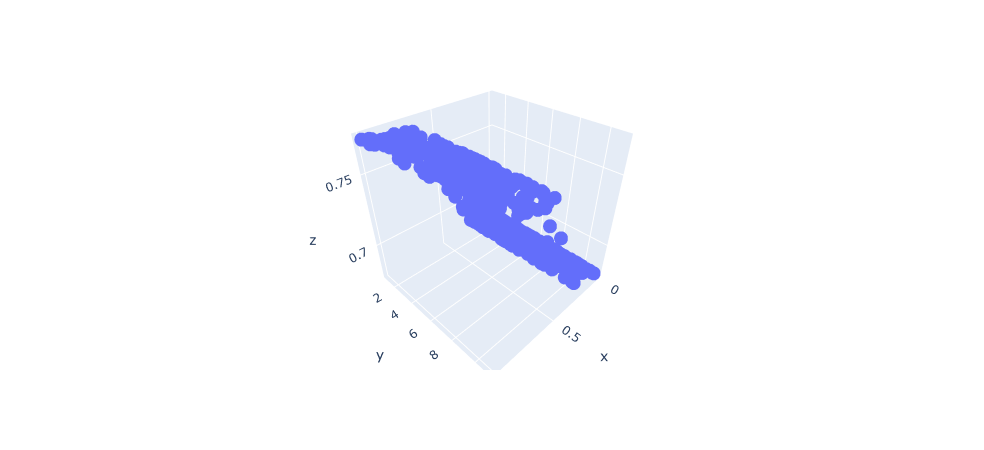

In [44]:
px.scatter_3d(x=XX[:,0], y=XX[:,1], z=B1basis@B1coef)

In [282]:
@singledispatch
def cc(nr_param, coef, constraint, y=None, B=None):
    """Check whether the coefficients in coef hold true to the constraint for
    the B-spline coefficients.

    Parameters:
    -----------
    nr_param : int    - Number of B-spline basis function coefficients.
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    y  : array        - Output data.
    B  : matrix       - B-spline basis matrix.

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V.
    """
    
    avail_constraints = ["inc", "dec","conv","conc","none","peak", "valley"]
    assert (constraint in avail_constraints), "Argument 'constraint' not available."

    threshold = 0 #1e-4;
    
    if constraint == "inc":
        v = np.diff(coef) < threshold
    elif constraint == "dec":
        v = np.diff(coef) > -threshold
    elif constraint == "conv":
        v = np.diff(coef, 2) < threshold
    elif constraint == "conc":
        v = np.diff(coef, 2) > -threshold
    elif constraint == "peak":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y and B-spline basis matrix B."
        peakidx = np.argmax(y)
        peak_spline_idx = np.argmax(B[peakidx,:])
        v = list(np.diff(coef[:peak_spline_idx]) < threshold) + list(np.diff(coef[peak_spline_idx-1:]) > -threshold)
    elif constraint == "valley":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y."
        valleyidx = np.argmin(y)
        valley_spline_idx = np.argmin(B[valleyidx,:])
        v = list(np.diff(coef[:valley_spline_idx]) > -threshold) + [False] + list(np.diff(coef[valley_spline_idx:]) < threshold)
    else:
        v = np.zeros(len(coef)-2)
    return list(v.astype(int))

@cc.register
def _(nr_param : tuple, coef, constraint, dim=0):
    """Check whether the coefficients in coef hold true to the constraint for 
    the tensor-product B-spline coefficients.

    Parameters:
    -----------
    nr_param : tuple  - Number of B-spline basis functions for both dimensions
                        of the tensor-product B-spline.
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    dim : int         - Either 0 or 1 indication the dimension of the constraint. 
                        0 is row-wise and 1 is column-wise. 

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V. 
    """
    print("TP constraint")
    avail_constraints = ["inc", "dec", "conv","conc", "none"]
    assert (constraint in avail_constraints), "Argument 'constraint' not available."
    threshold = 0
    
    if constraint == "inc":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), axis=dim) < threshold
    elif constraint == "dec":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), axis=dim) > -threshold
    elif constraint == "conv":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), 2,  axis=dim) < threshold
    elif constraint == "conc":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), 2,  axis=dim) > -threshold
    else:
        order = nr_param[0] if dim == 1 else nr_param[1]
        v = np.zeros(nr_param[0]*nr_param[1]-2*order)
    return list(v.ravel().astype(int))

@cc.register
def _(nr_param : dict, coef, basis=0, y=0):
    """Checks the respective parts of the coef vector against 
    the respective constraint constraints. 
    
    Paramters:
    ----------
    nr_param : dict  - Model description dictionary, e.g.
                        >>>m = ( ("t(1,2)", (5,5), ("conc", "none"), 6000, ("e", "q")), 
                           ("s(1)", 10, "inc", 2000, "e"), 
                           ("s(2)", 15, "inc", 10, "q"), 
                           )
                        >>>nr_param = dict()
                        >>>for i in m:
                               nr_param[i[0]] = dict(nr_param=i[1], constraint=i[2], lam=i[3], knot_type=i[4])
   
    coef : array    - Vector of coefficients.
    
    Returns:
    --------
    v : list    - Diagonal elements of the weighting matrix V.
    
    """
    print("INside check_full")
    i, v = 0, []
    for k,val in nr_param.items():
        if k[0].startswith("s"):
            c = coef[i:val["nr_param"]+i]
            v.append(cc(val["nr_param"], coef=c, constraint=val["constraint"], y=y, B=basis[:, i:val["nr_param"]+i]))
        elif k[0].startswith("t"):
            c = coef[i:np.prod(val["nr_param"])+i]
            v1 = cc(val["nr_param"], c, constraint=val["constraint"][0], dim=int(k[2])-1)
            v2 = cc(val["nr_param"], c, constraint=val["constraint"][1], dim=int(k[2])-1)
            v.append((v1,v2))
        else:
            print("Only B-splines (s) and tensor-product B-splines (t) are supported!")
            return
        i += np.prod(val["nr_param"])
    return v


In [74]:
x1 = np.linspace(0,1,100)
x2 = np.linspace(2,4,100)
x1g, x2g = np.meshgrid(x1, x2)
Bs = Bspline()
B1 = Bs.basismatrix(x1g.ravel(), nr_splines=10)["basis"]
B2 = Bs.basismatrix(x2g.ravel(), nr_splines=8)["basis"]

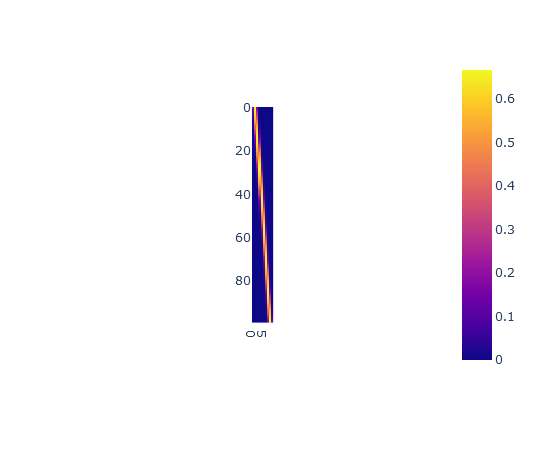

In [76]:
px.imshow(Bs.basismatrix(x1)["basis"])

In [72]:
np.trace((B1.T @ B1) @ np.linalg.pinv(B1.T@B1))

9.999999999999979

In [60]:
T = np.zeros((np.prod(x1g.shape), 80))
for i in range(T.shape[0]):
    T[i,:] = np.kron(B2[i,:], B1[i,:])

In [63]:
T[:,0].reshape()

(10000,)

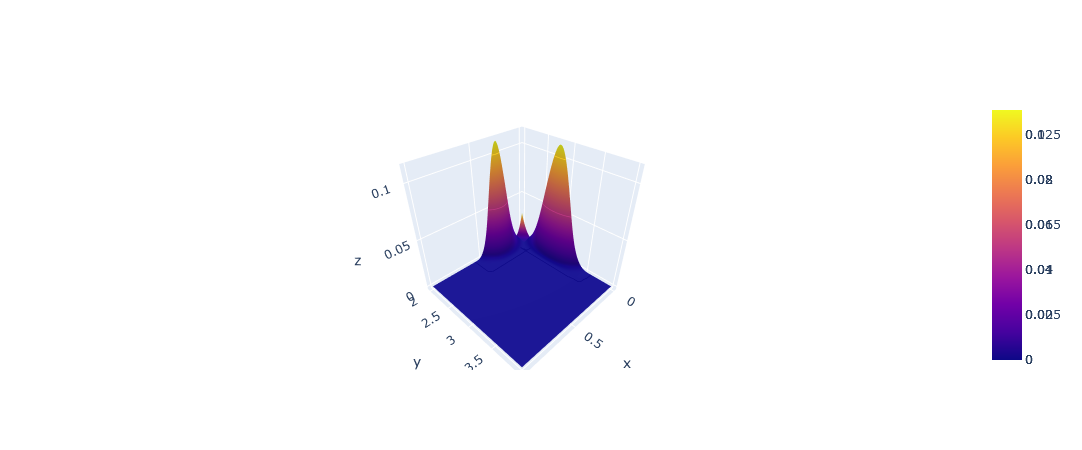

In [69]:
fig = go.Figure()
fig.add_trace(go.Surface(x=x1g, y=x2g, z=T[:,0].reshape(x1g.shape)))
fig.add_trace(go.Surface(x=x1g, y=x2g, z=T[:,3].reshape(x1g.shape)))
fig.add_trace(go.Surface(x=x1g, y=x2g, z=T[:,30].reshape(x1g.shape)))

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

In [7]:
D1 = mapping_matrix(n_param=6)
I2 = np.eye(5)

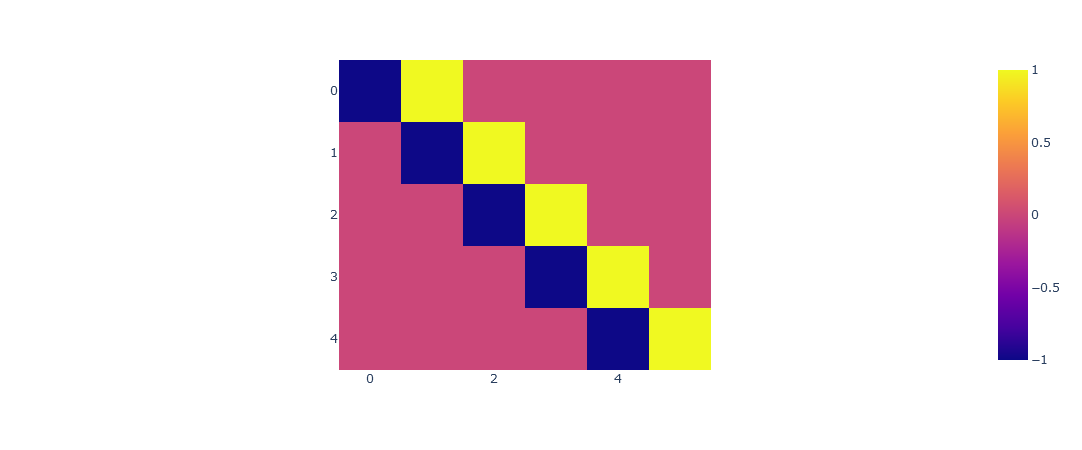

In [8]:
px.imshow(D1)

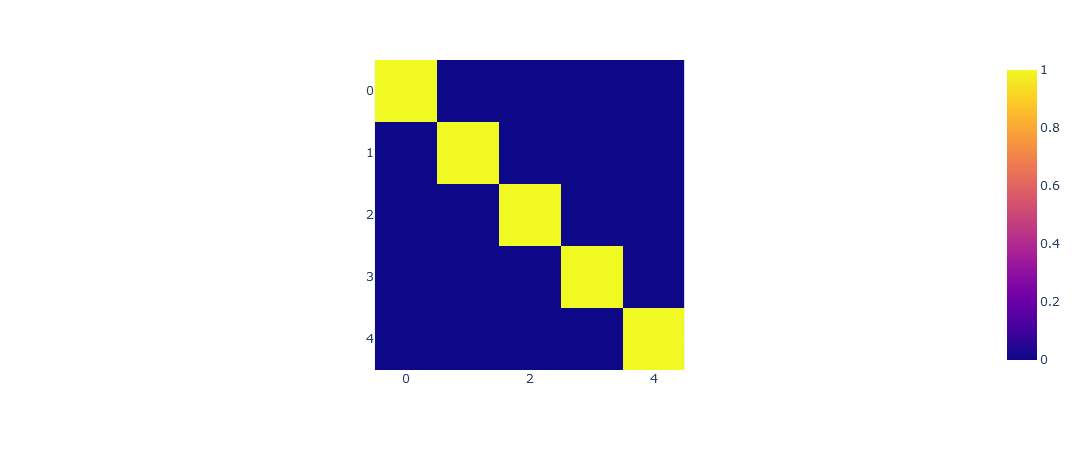

In [9]:
px.imshow(I2)

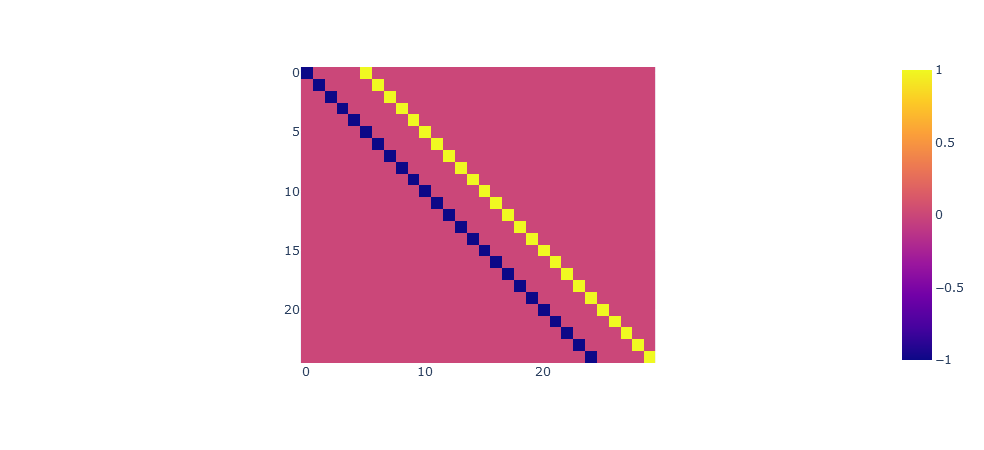

In [11]:
px.imshow(np.kron(D1,I2))